In [1]:
import matplotlib
# matplotlib.use('nbagg')
import matplotlib.style
matplotlib.style.use('seaborn-notebook')
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
from IPython.core.display import display, HTML

from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from  statsmodels.stats import proportion
import scipy

plt.rcParams['text.color'] = 'black'


In [2]:
def percent_converter(x):
    print(x)
    if type(x) is type(''):
        return float(x.strip('%'))/100.0
    else:
        return pd.nan

original_data = pd.read_csv('data/2014-2015/801_ks2.csv', na_values=('SUPP') )
                   #converters={'PGREADWRITTAMATX':percent_converter, 'PBREADWRITTAMATX' : percent_converter} )

data = original_data.dropna(subset=['TAPS'])
data = data[ data['TOWN'] == 'Bristol']

# Clean up percentage strings
for key in ['PTREADWRITTAMATX', 'PBREADWRITTAMATX', 'PGREADWRITTAMATX', 
            'PTREADWRITTAMATAX', 'PBREADWRITTAMATAX', 'PGREADWRITTAMATAX', 
            'TAPS']:
    data[key].replace('%','',regex=True, inplace=True)
    data.loc[:, key] = pd.to_numeric(data.loc[:,key], errors='coerce')

data['SHORTPOSTCODE'] = data['PCODE'].str.extract('(.+)\s.*')    
data.set_index( ['SCHNAME'], inplace=True )
national = original_data[ original_data[ 'SCHNAME'] =='NATIONAL' ]
average_pt_score = data['TAPS']
overall_added_value = data['OVAMEAS']
overall_added_value_95p_up = data['OUCONF']
overall_added_value_95p_low = data['OLCONF']



/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


In [3]:
def beta_binomial_credible_interval(prior_mu, prior_M, obs_N, obs_k, percent_interval=(0.1, 0.9)):
    # Likelihood
    # Posterior
    post_alpha = obs_k + prior_mu * prior_M
    post_beta = obs_N - obs_k + prior_M * (1 - prior_mu)
    confidence_low = scipy.stats.beta.ppf(percent_interval[0], post_alpha, post_beta)
    confidence_high = scipy.stats.beta.ppf(percent_interval[1], post_alpha, post_beta)
    return confidence_low, confidence_high






# Key Stage 2 and SATs

Key Stages and their evaluations are explained on this [BBC website](http://www.bbc.co.uk/schools/parents/how_is_my_child_doing/). 

Key Stage 2 defines the educational programme during school years 3 to 6, for pupils aged 7 to 11. At the end of Key Stage 2, children are evaluated using Standard Assesment Tasks (SATs) in English (reading and writing), maths and science. The results of the SATs evaluations are given using "National Curriculum levels" for each subject, or just "level". It is expected that most children will achieve at least level 4 in all subjects by the end of Key Stage 2. Futhermore, the Department for Education [gives the following guidance](http://www.education.gov.uk/schools/performance/archive/schools_10/s11.shtml):
- Pupils reaching level 4 at the end of KS2 are expected a GCSE Grade C or above.
- Pupils reaching level 5 at the end of KS2 are expected a GCSE Grade B or above.

One last note: the use of National Curriculum levels to present SATs results will be abolished in 2016. 

# Bristol primary schools

The data set was downloaded from the Government's [school comparison tool](https://www.compare-school-performance.service.gov.uk/)

## School rankings per Average Point Score

In [4]:
#best_schools = data[data.TAPS >= national.TAPS[0] ].sort_values('TAPS')
best_schools = data.sort_values('TAPS')

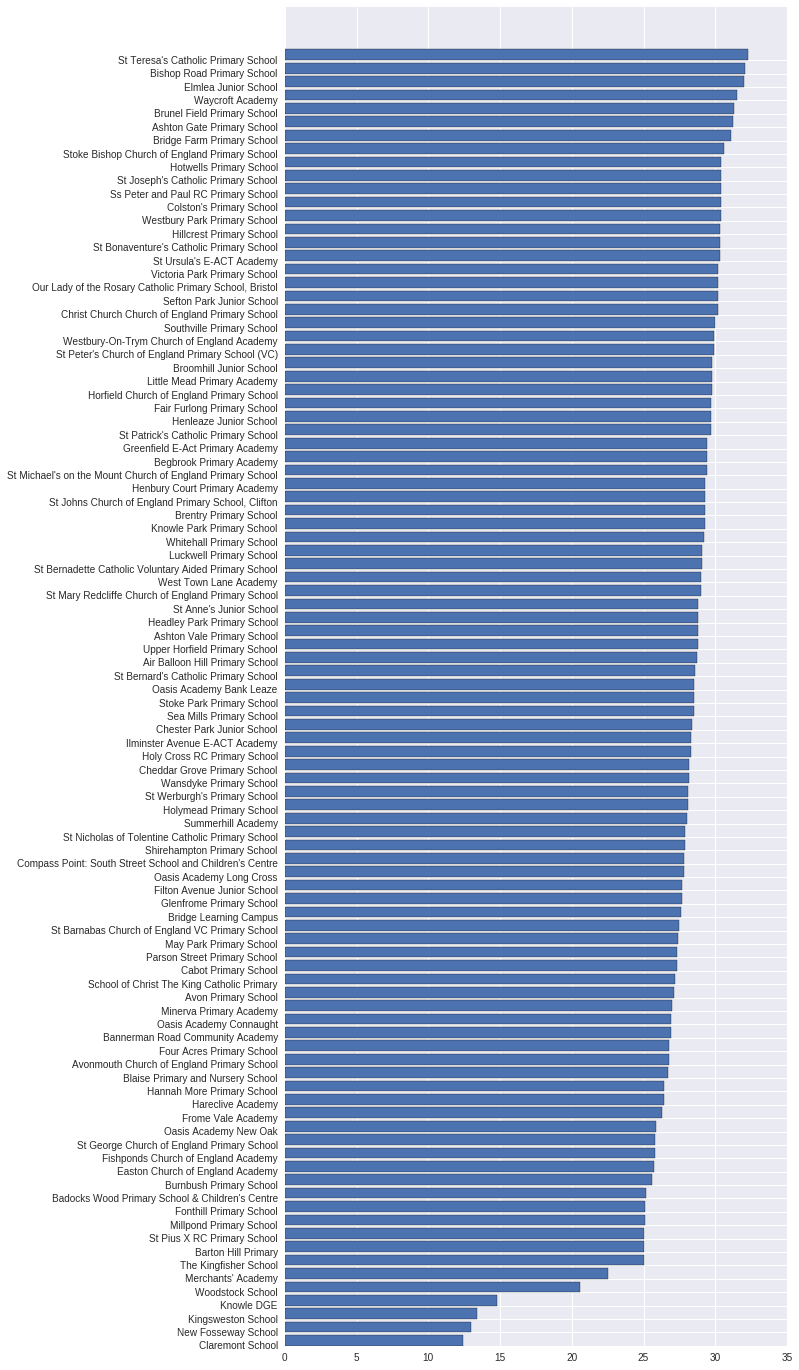

In [5]:
fig, ax1 = plt.subplots(figsize=(9, 24))
ax1.barh( np.arange(len(best_schools)), best_schools.TAPS)
ax1.set_yticklabels(best_schools.index)
_ = ax1.set_yticks(np.arange(len(best_schools)))
plt.show()

## KS2 Level 4 performance

Ranking of all schools by percentage of pupils achieving at least level 4 in Math, Reading and Writing at the Key Stage 2 tests. 

For each school:
- triangles represent the percentage of all pupils achieving level 4;
- red circles represent the percentage of girls achieving level 4;
- blue circles represent the percentage of all boys achieving level 4;

The horizontal line highlights the discrepacncies between boys and girls results, a red line meaning girls overperform and a blue line meaning boys overperform.

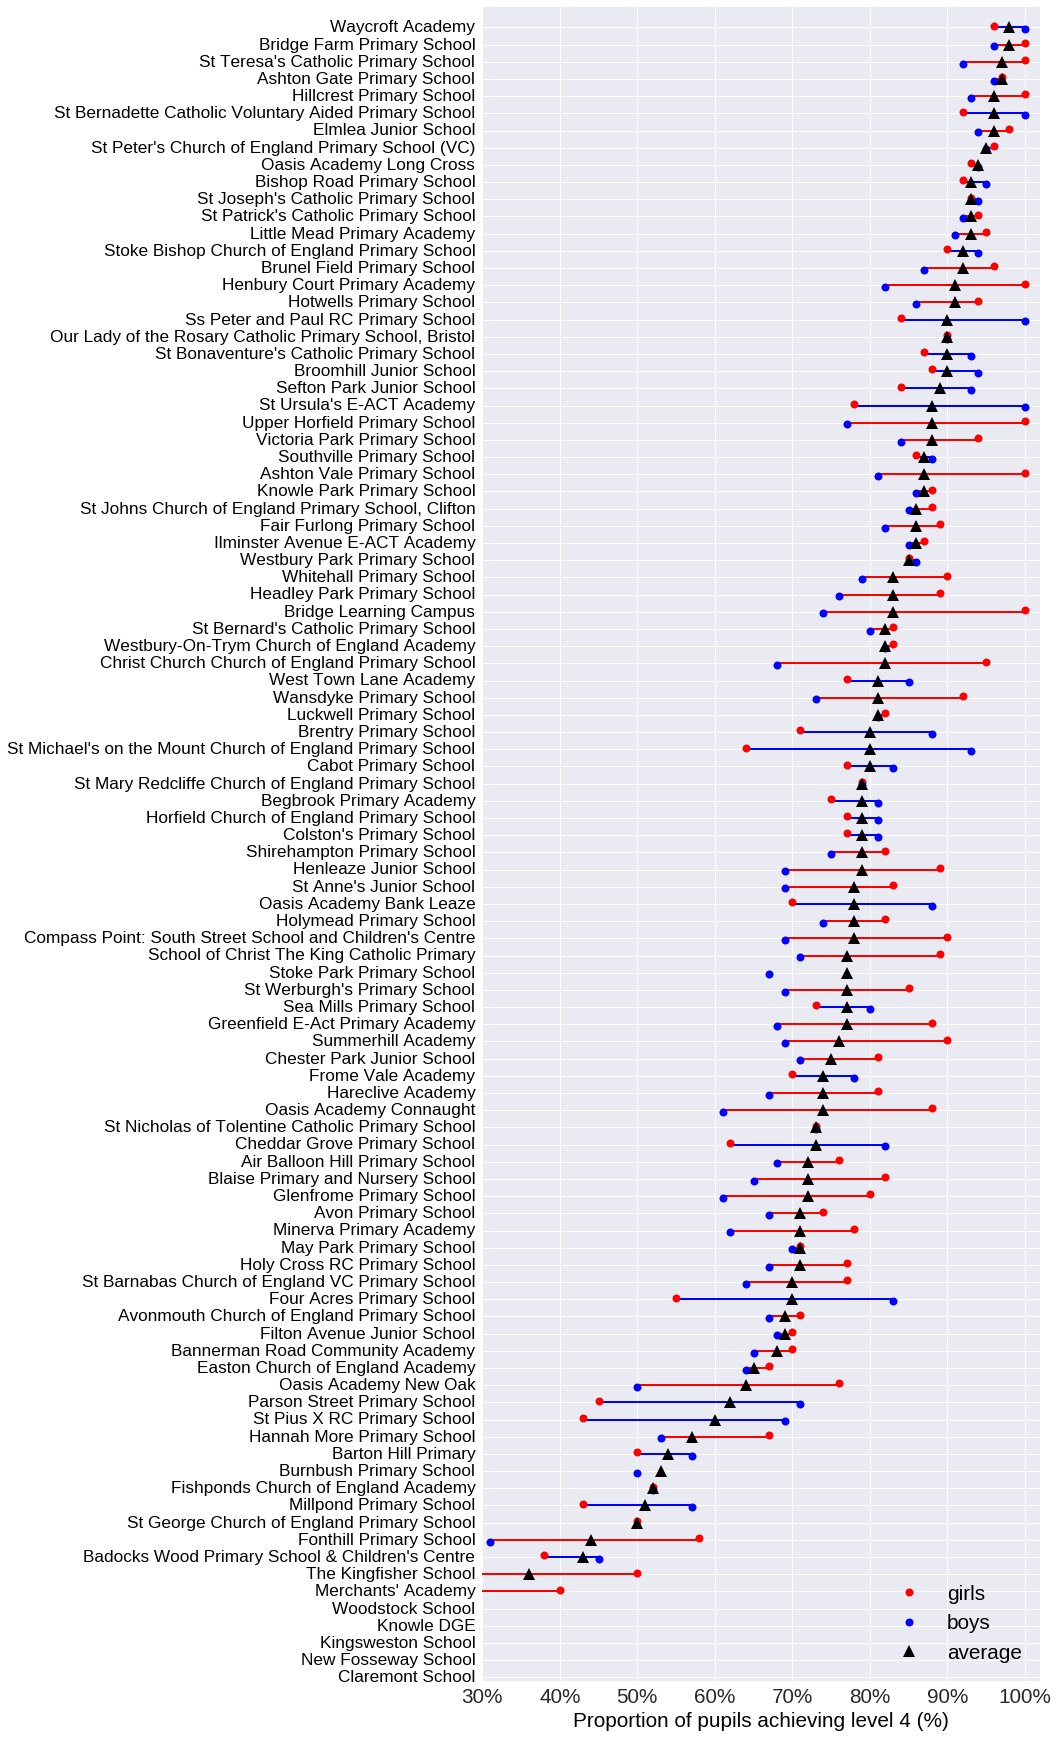

In [6]:
level4_math_reading = best_schools[ ['PTREADWRITTAMATX', 
                                     'PGREADWRITTAMATX', 
                                     'PBREADWRITTAMATX',
                                     'TELIG', 'BELIG', 'GELIG',
                                     'TAPS'] ].sort_values('PTREADWRITTAMATX')
level4_math_reading = level4_math_reading[level4_math_reading['PTREADWRITTAMATX'].notnull()]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 30))

school_idx = np.arange(len(level4_math_reading))
level4_average = level4_math_reading.PTREADWRITTAMATX
level4_girls = level4_math_reading.PGREADWRITTAMATX
level4_boys = level4_math_reading.PBREADWRITTAMATX
delta = (level4_girls - level4_boys).values
nb_pupils = level4_math_reading.TELIG
nb_girls = level4_math_reading.GELIG
nb_boys = level4_math_reading.BELIG


low_interval_girls, up_interval_girls = proportion.proportion_confint(
    nb_girls * level4_girls / 100.0, nb_girls, alpha=0.05, method='jeffrey')
low_error_girls, up_error_girls = level4_girls - 100 * low_interval_girls, 100 * up_interval_girls - level4_girls

low_interval_boys, up_interval_boys = proportion.proportion_confint(
    nb_boys * level4_boys / 100.0, nb_boys, alpha=0.05, method='jeffrey')
low_error_boys, up_error_boys = level4_boys - 100 * low_interval_boys, 100 * up_interval_boys - level4_boys

# Need to set labels first otherwise centering / hspacing don't work well. 
ax1.set_yticklabels(level4_math_reading.index, va='center', linespacing=2, fontsize='x-large', color='black')
_ = ax1.set_yticks(np.arange(len(level4_math_reading)))
ax1.set_ylim(-.2, len(level4_math_reading)+0.2)

# Average
ax1.hlines( school_idx[delta < 0], level4_girls[delta < 0], level4_boys[delta < 0], color='b', linewidth=2)
ax1.hlines( school_idx[delta > 0], level4_boys[delta > 0], level4_girls[delta > 0], color='r', linewidth=2)
#ax1.hlines( school_idx, low_interval*100, up_interval*100, color='k', linewidth=1)

#ax1.errorbar( level4_boys, school_idx - 0.15, xerr=[low_error_boys, up_error_boys], fmt='.', color='b', linewidth=1, mew=0)
#ax1.errorbar( level4_girls, school_idx + 0.15, xerr=[low_error_girls, up_error_girls], fmt='.', color='r', linewidth=1, mew=0)
ax1.plot( level4_girls, school_idx + 0.1, 'ro', markersize=8, label='girls')
ax1.plot( level4_boys, school_idx - 0.1, 'bo', markersize=8, label='boys')
ax1.plot( level4_average, school_idx, 'k^', markersize=12, label='average')

#ax1.hlines( school_idx+0.1, 100*low_interval_girls, 100*up_interval_girls, color='r', linewidth=1)
#ax1.hlines( school_idx-0.1, 100*low_interval_boys, 100*up_interval_boys, color='b', linewidth=1)

ax1.set_xlim(30, 102)
# Replace Y labels by school names
ax1.set_xticklabels(np.arange(0, 100, 10), fontsize='xx-large')
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f%%'))

ax1.set_xlabel('Proportion of pupils achieving level 4 (%)', fontsize='xx-large', color='black')
ax1.legend(loc='lower right', fontsize='xx-large')

plt.savefig('schools_level4.png', bbox_inches='tight')


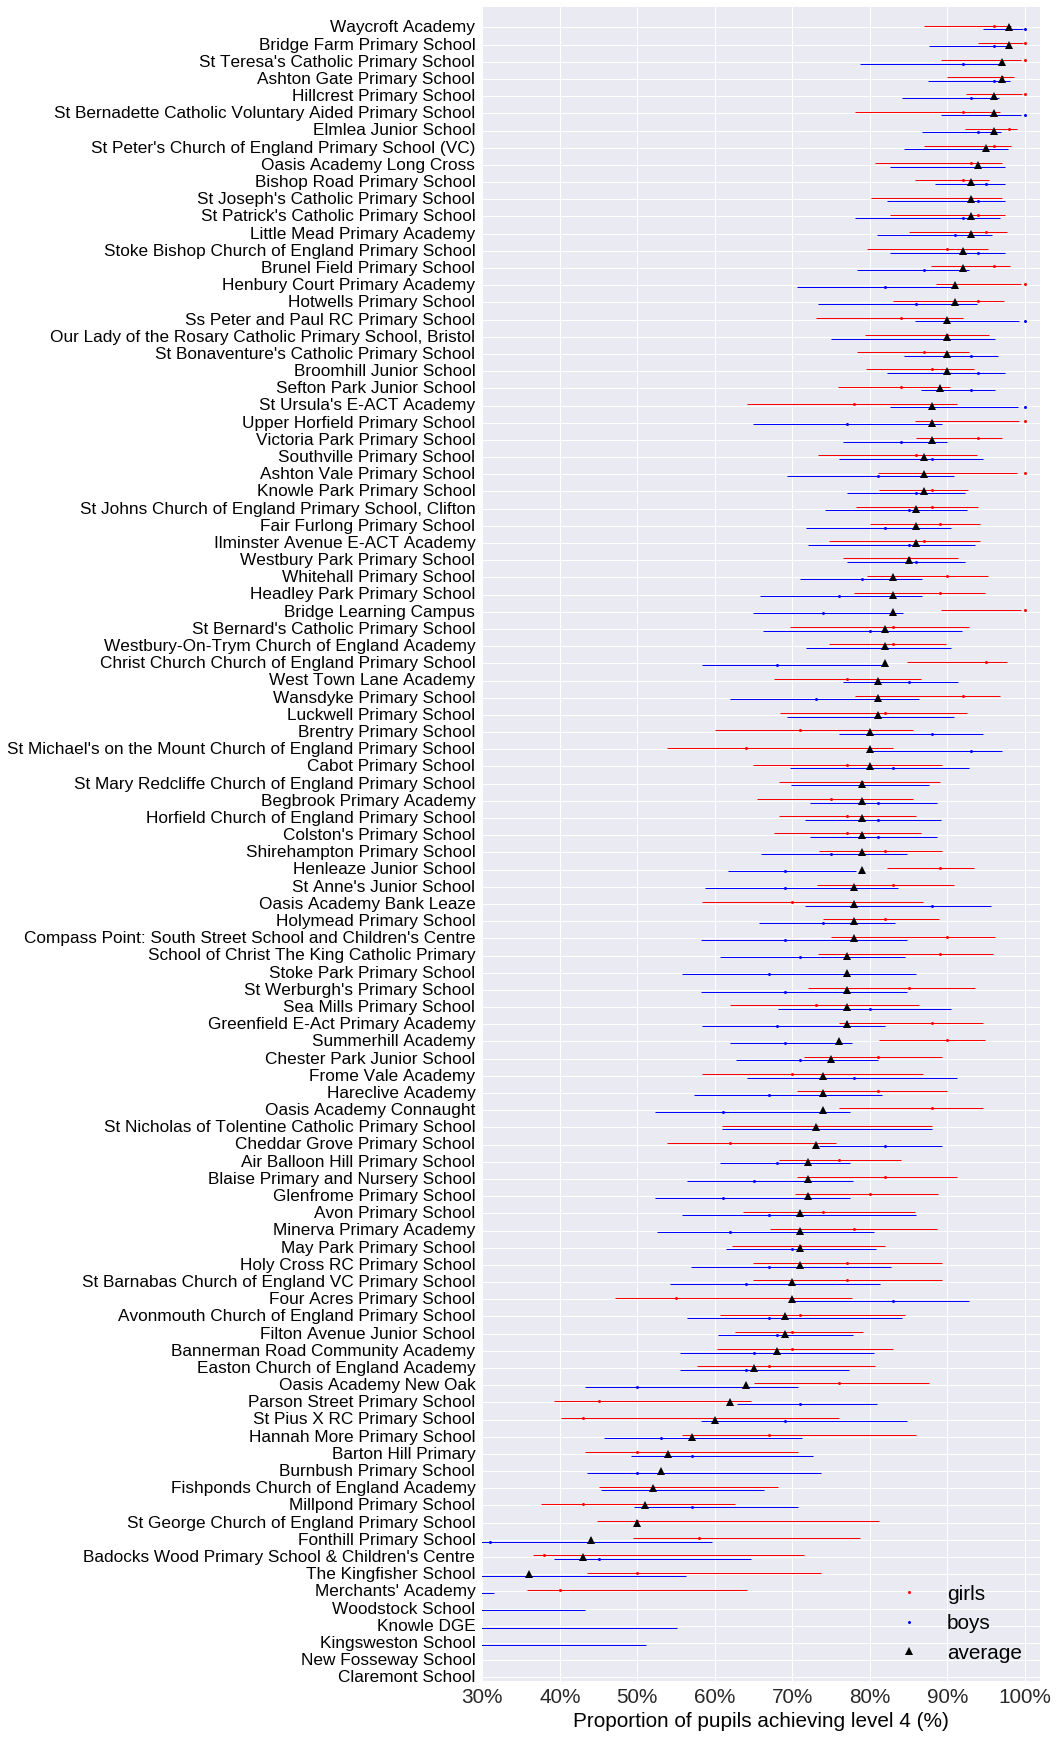

In [7]:
level4_math_reading = best_schools[ ['PTREADWRITTAMATX', 
                                     'PGREADWRITTAMATX', 
                                     'PBREADWRITTAMATX',
                                     'TELIG', 'BELIG', 'GELIG',
                                     'TAPS'] ].sort_values('PTREADWRITTAMATX')
level4_math_reading = level4_math_reading[level4_math_reading['PTREADWRITTAMATX'].notnull()]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 30))

school_idx = np.arange(len(level4_math_reading))
level4_average = level4_math_reading.PTREADWRITTAMATX
level4_girls = level4_math_reading.PGREADWRITTAMATX
level4_boys = level4_math_reading.PBREADWRITTAMATX
delta = (level4_girls - level4_boys).values
nb_pupils = level4_math_reading.TELIG
nb_girls = level4_math_reading.GELIG
nb_boys = level4_math_reading.BELIG


prior_mu = 0.8
prior_N = 5.0

low_interval_girls, up_interval_girls = beta_binomial_credible_interval(
    prior_mu, prior_N, nb_girls, nb_girls * level4_girls / 100.0, [0.1, 0.9] )

low_interval_boys, up_interval_boys = beta_binomial_credible_interval(
    prior_mu, prior_N, nb_boys, nb_boys * level4_boys / 100.0, [0.1, 0.9] )

# Need to set labels first otherwise centering / hspacing don't work well. 
ax1.set_yticklabels(level4_math_reading.index, va='center', linespacing=2, fontsize='x-large', color='black')
_ = ax1.set_yticks(np.arange(len(level4_math_reading)))
ax1.set_ylim(-.2, len(level4_math_reading)+0.2)

# Average

ax1.plot( level4_girls, school_idx + 0.1, 'ro', markersize=3, label='girls')
ax1.plot( level4_boys, school_idx - 0.1, 'bo', markersize=3, label='boys')
ax1.plot( level4_average, school_idx, 'k^', markersize=8, label='average')

ax1.hlines( school_idx+0.1, 100*low_interval_girls, 100*up_interval_girls, color='r', linewidth=1)
ax1.hlines( school_idx-0.1, 100*low_interval_boys, 100*up_interval_boys, color='b', linewidth=1)

ax1.set_xlim(30, 102)
# Replace Y labels by school names
ax1.set_xticklabels(np.arange(0, 100, 10), fontsize='xx-large')
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f%%'))

ax1.set_xlabel('Proportion of pupils achieving level 4 (%)', fontsize='xx-large', color='black')
ax1.legend(loc='lower right', fontsize='xx-large')

plt.savefig('schools_level4_ci.png', bbox_inches='tight')
plt.show()

## KS2 Level 5 performance 

The figure shows the ranking of schools by percentage of pupils achieving at least level 5 in Math, Reading and Writing at the Key Stage 2 tests. I have added uncertainty bars to represent the uncertainty caused by the small sample sizes, as in some school only a handful of pupils achieve level 5, either because the school population is small or the achievement rate is low.


In [8]:
#level5_average.mean()

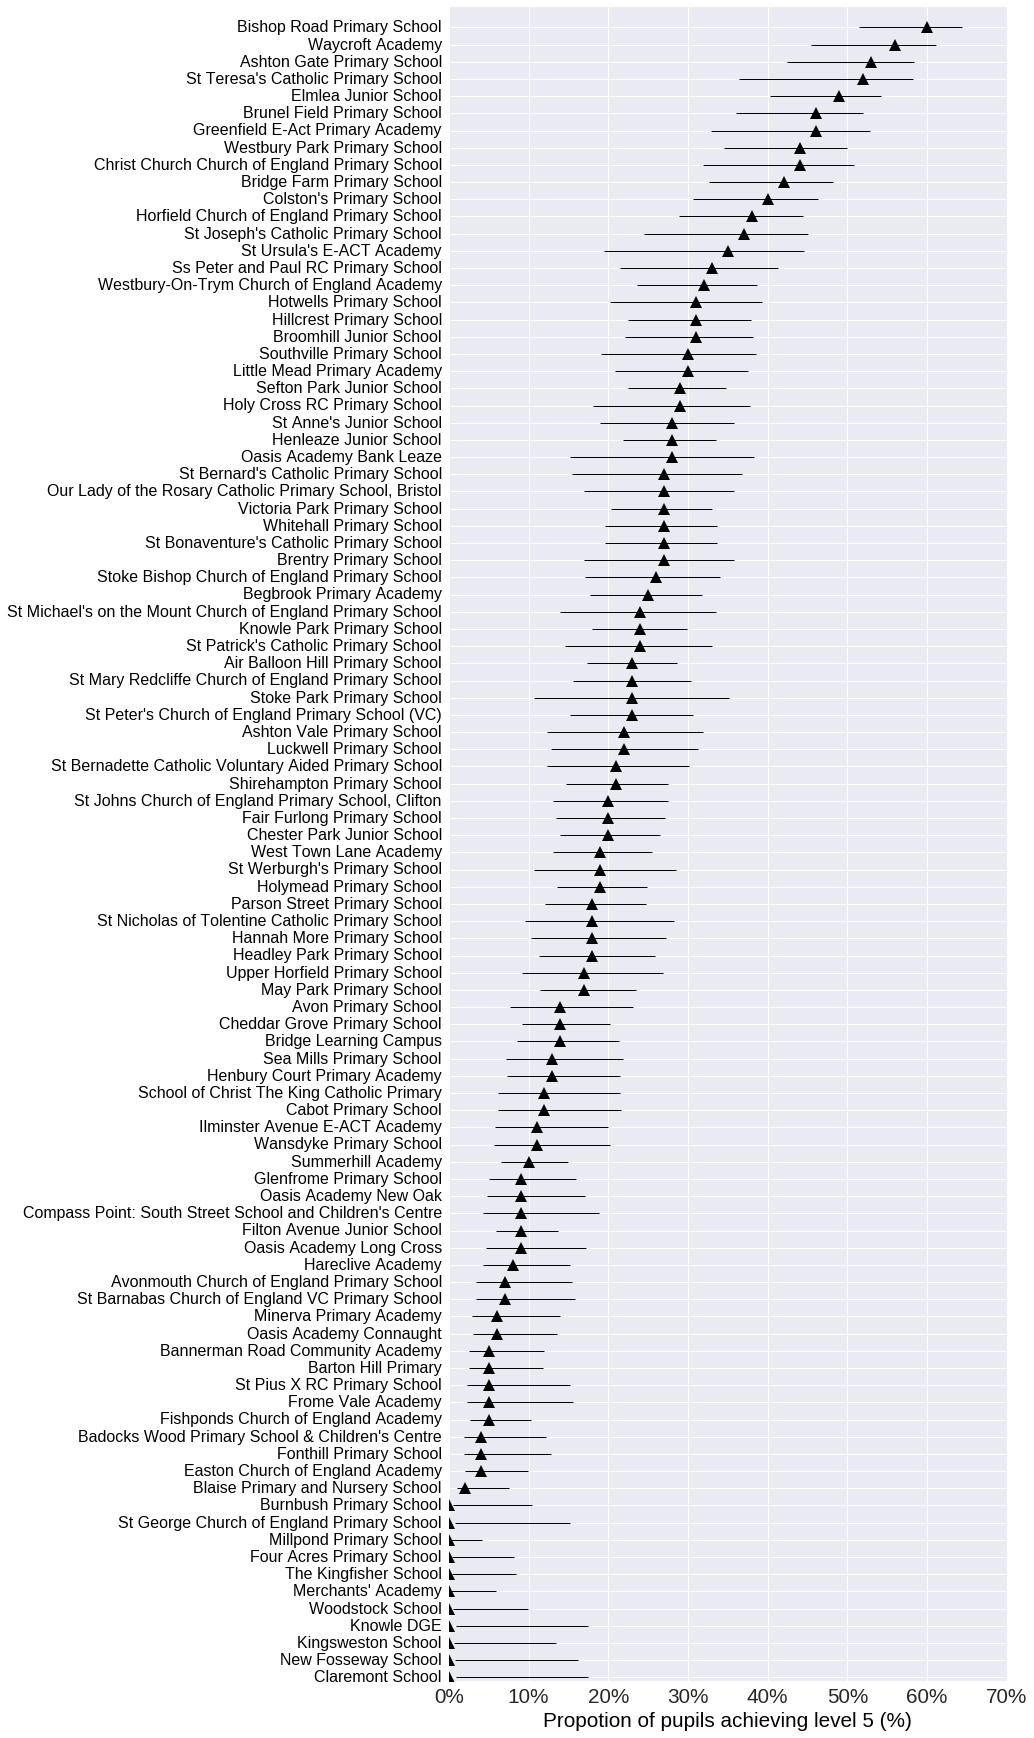

In [9]:
level5_math_reading = best_schools[ ['PTREADWRITTAMATAX', 
                                     'PGREADWRITTAMATAX', 
                                     'PBREADWRITTAMATAX',
                                     'TELIG', 'BELIG', 'GELIG',
                                     'TAPS'] ].sort_values('PTREADWRITTAMATAX')
level5_math_reading = level5_math_reading[level5_math_reading['PTREADWRITTAMATAX'].notnull()]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 30))

school_idx = np.arange(len(level5_math_reading))
level5_average = level5_math_reading.PTREADWRITTAMATAX
level5_girls = level5_math_reading.PGREADWRITTAMATAX
level5_boys = level5_math_reading.PBREADWRITTAMATAX
delta = (level5_girls - level5_boys).values
nb_pupils = level5_math_reading.TELIG

#low_interval, up_interval = proportion.proportion_confint(
#    nb_pupils * level5_average / 100.0, nb_pupils, alpha=0.10, method='jeffrey')

prior_mu = 0.2
prior_N = 5.0

low_error, up_error = beta_binomial_credible_interval(
    prior_mu, prior_N, nb_pupils, nb_pupils * level5_average/100, [0.1, 0.9] )

#low_error, up_error = level5_average - 100 * low_interval, 100 * up_interval - level5_average

# Need to set labels first otherwise centering / hspacing don't work well. 
ax1.set_yticklabels(level5_math_reading.index, fontsize=16, va='center', linespacing=2, color='black')
_ = ax1.set_yticks(np.arange(len(level5_math_reading)))
ax1.set_ylim(-.2, len(level4_math_reading)+0.2)

# Average
ax1.hlines( school_idx, 100*low_error, 100*up_error, color='k', linewidth=1)
ax1.plot( level5_average, school_idx, 'k^', markersize=12, label='average')

# Replace Y labels by school names
ax1.set_xticklabels(np.arange(0, 100, 10), fontsize='xx-large')
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f%%'))

ax1.set_xlabel('Propotion of pupils achieving level 5 (%)', fontsize='xx-large', color='black')
plt.savefig( 'level5_ci.png', bbox_inches='tight')

In [10]:
level5_average.mean()

19.896907216494846

In [11]:
math_reading_level4_years = best_schools[ ['TAPS', 'PTREADWRITTAMATX12', 'PTREADWRITTAMATX13', 'PTREADWRITTAMATX14', 'PTREADWRITTAMATX15' ] ]
math_reading_level4_years.sort_values('TAPS')               

,TAPS,PTREADWRITTAMATX12,PTREADWRITTAMATX13,PTREADWRITTAMATX14,PTREADWRITTAMATX15
SCHNAME,,,,,
Claremont School,12.4,NaN,NaN,NaN,0%
New Fosseway School,13.0,0%,NaN,0%,0%
Kingsweston School,13.4,0%,0%,0%,0%
Knowle DGE,14.8,0%,0%,8%,0%
Woodstock School,20.6,0%,0%,14%,17%
Merchants' Academy,22.5,NaN,0%,29%,21%
The Kingfisher School,25.0,NaN,NaN,40%,36%
Barton Hill Primary,25.0,NaN,NaN,NaN,54%
St Pius X RC Primary School,25.0,47%,58%,56%,60%


In [12]:
math_reading_level5_years = best_schools[ ['TAPS', 'PTREADWRITTAMATAX12', 'PTREADWRITTAMATAX13', 'PTREADWRITTAMATAX14', 'PTREADWRITTAMATAX15' ] ]
math_reading_level5_years.sort_values('TAPS')               

,TAPS,PTREADWRITTAMATAX12,PTREADWRITTAMATAX13,PTREADWRITTAMATAX14,PTREADWRITTAMATAX15
SCHNAME,,,,,
Claremont School,12.4,NaN,NaN,NaN,0%
New Fosseway School,13.0,0%,NaN,0%,0%
Kingsweston School,13.4,0%,0%,0%,0%
Knowle DGE,14.8,0%,0%,0%,0%
Woodstock School,20.6,0%,0%,0%,0%
Merchants' Academy,22.5,NaN,0%,0%,0%
The Kingfisher School,25.0,NaN,NaN,8%,0%
Barton Hill Primary,25.0,NaN,NaN,NaN,5%
St Pius X RC Primary School,25.0,7%,8%,11%,5%


# Total Average Point Score

The performance tables also give the Total Average Point Score (TAPS) for each school. As detailed [here](http://www.education.gov.uk/schools/performance/archive/primary_04/p8.shtml) the TAPS is a weighted average of the results across all levels. The TAPS metrics is thus a combination of several outcome variables and I find it difficult to interpret TAPS when comparing schools (i.e. what is the meaning of school X perform 2.4 TAPS better than school Y?). I prefer to use the TAPS distribution of schools in Bristol to group them in quantiles. For example the quantile 60% - 80% includes all schools with a TAPS higher than 60% of the schools but lower than the TAPS of the 20% top schools.

In [13]:
quantile_list = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
data['quantile_level4'] = 0
data['quantile_level5'] = 0
data['quantile_taps'] = 0
for k, q in enumerate(quantile_list[:-1]):
    q_next = quantile_list[k+1]

    data.loc[ (data.PTREADWRITTAMATX > data.PTREADWRITTAMATX.quantile(q)) 
         & (data.PTREADWRITTAMATX <= data.PTREADWRITTAMATX.quantile(q_next)), 'quantile_level4'] = k

    data.loc[ (data.PTREADWRITTAMATAX > data.PTREADWRITTAMATAX.quantile(q)) 
         & (data.PTREADWRITTAMATAX <= data.PTREADWRITTAMATAX.quantile(q_next)), 'quantile_level5'] = k

    data.loc[ (data.TAPS > data.TAPS.quantile(q)) 
         & (data.TAPS <= data.TAPS.quantile(q_next)), 'quantile_taps'] = k


In [14]:
df_list = []
data['ADDRESS2'].fillna( data['SHORTPOSTCODE'], inplace=True )

for k, q in enumerate(quantile_list[:-1]):
    df_list.append( data[ data['quantile_taps'] == k ] )
max_elts = max( map(len, df_list ))

# quantile_df_for_display = pd.DataFrame()
# for k, v in enumerate(df_list):
#     value_list = list(df_list[k].index) + list( [''] * (max_elts - len(df_list[k].index)) )
#     key_name = '{0:.0f}% - {1:.0f}%'.format(quantile_list[k]*100, quantile_list[k+1]*100)
#     quantile_df_for_display[key_name] = value_list
    
def html_list(l):
    html_str = '<ul><li>{0}</li></ul>'.format('</li><li>'.join(l))
    return HTML(html_str)

for k, df in enumerate(df_list):
#     df_with_name = pd.DataFrame( {'name' : df.index, 'location':df['ADDRESS2']} )
    df_with_name = df.index.map(str) + ' (' + df['ADDRESS2'] + ')'
    display( HTML('<h2>{0:.0f}% - {1:.0f}%</h2>'.format(quantile_list[k]*100, quantile_list[k+1]*100)))
    display(html_list(list(df_with_name.values)))

# Postcode statistics

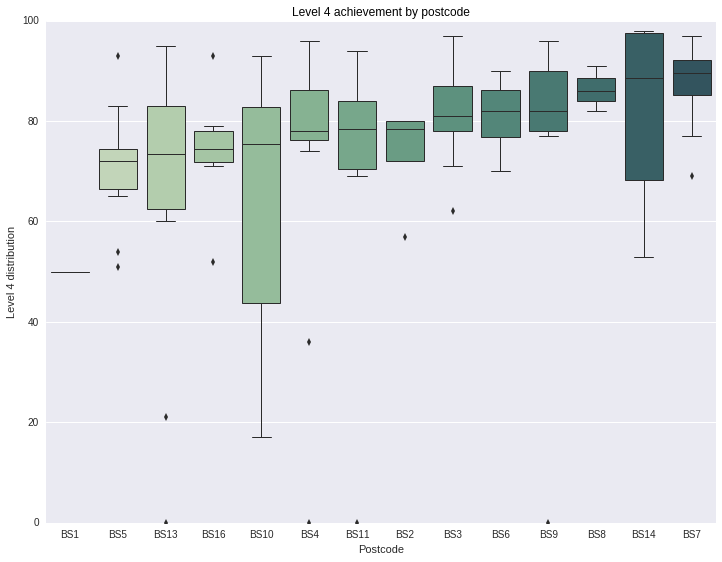

In [15]:
fig, ax = plt.subplots(figsize=(12, 9))
#best_schools.boxplot( column='TAPS', by='SHORTPOSTCODE', ax=ax)
#best_schools.boxplot( column='PTREADWRITTAMATX', by='SHORTPOSTCODE', ax=ax)
average_level4_postcode = best_schools[['PTREADWRITTAMATX', 'SHORTPOSTCODE']].groupby('SHORTPOSTCODE').median().sort_values('PTREADWRITTAMATX')

pal = sns.cubehelix_palette( len(best_schools['SHORTPOSTCODE'].unique()), rot=-.5, dark=.3)


sns.boxplot(best_schools['SHORTPOSTCODE'], best_schools['PTREADWRITTAMATX'], 
               order=list(average_level4_postcode.index), palette=pal, linewidth=1)


ax.set_title('Level 4 achievement by postcode')
ax.set_ylabel('Level 4 distribution')
ax.set_xlabel('Postcode')

In [16]:
data[data['SHORTPOSTCODE'] == 'BS14']['PTREADWRITTAMATX']

SCHNAME
Bridge Farm Primary School                               98
Burnbush Primary School                                  53
Oasis Academy New Oak                                    64
St Bernadette Catholic Voluntary Aided Primary School    96
Wansdyke Primary School                                  81
Waycroft Academy                                         98
Name: PTREADWRITTAMATX, dtype: int64

# Boys / girls results 

Reaching level 4 is modelled as a Bernoulli trial. 


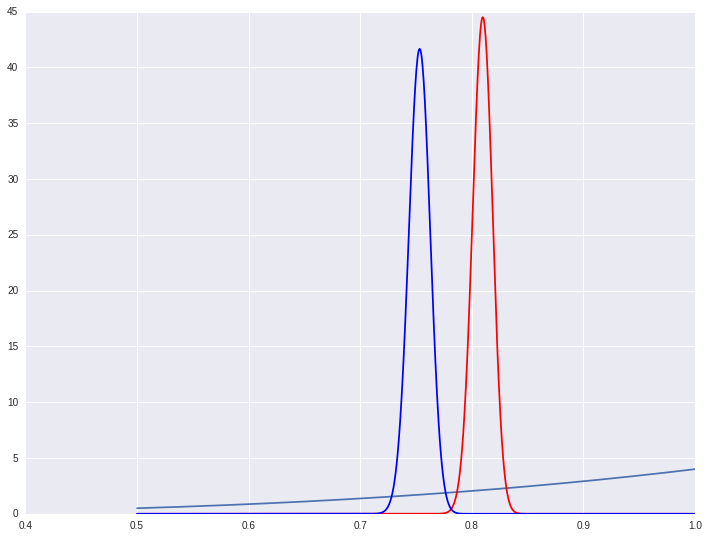

In [17]:
bg_ratio = level4_math_reading.GELIG / (1.0 * level4_math_reading.TELIG)
fig, ax = plt.subplots(figsize=(12, 9))

# Nb pupils success at passing Level 4 conditioned on boys/girls group
nb_girls = level4_math_reading.GELIG.sum()
nb_boys = level4_math_reading.BELIG.sum()
nb_girls_level4 = (level4_math_reading.PGREADWRITTAMATX/100.0 * level4_math_reading.GELIG).sum()
nb_boys_level4 = (level4_math_reading.PBREADWRITTAMATX/100.0 * level4_math_reading.BELIG).sum()

def beta_binomial_posterior(prior_mu, prior_M, obs_N, obs_k, theta):
    # Likelihood
    # Posterior
    post_alpha = obs_k + prior_mu * prior_M
    post_beta = obs_N - obs_k + prior_M * (1 - prior_mu)
    post_theta_pdf = scipy.stats.beta.logpdf(theta, post_alpha, post_beta)
    # post_theta_pdf = post_theta_pdf / sum(post_theta_pdf)
    return post_theta_pdf

thetas = np.linspace(0.5, 1.0, 1000)
prior_mu = 0.8
prior_N = 5.0
prior_alpha = prior_mu * prior_N 
prior_beta = prior_N - prior_alpha
prior_pdf = scipy.stats.beta.logpdf(thetas, prior_alpha, prior_beta)
#prior_pdf = prior_pdf/sum(prior_pdf)

post_theta_girls = beta_binomial_posterior( prior_mu, prior_N, nb_girls, nb_girls_level4, thetas )
post_theta_boys = beta_binomial_posterior( prior_mu, prior_N, nb_boys, nb_boys_level4, thetas )

girls10, girls90 = beta_binomial_credible_interval( prior_mu, prior_N, nb_girls, nb_girls_level4 )

plt.plot(thetas, np.exp(prior_pdf))
plt.plot(thetas, np.exp(post_theta_girls), 'r-')
plt.plot(thetas, np.exp(post_theta_boys), 'b-')

#ax.scatter(bg_ratio, level4_math_reading.PTREADWRITTAMATX - level4_math_reading.PTREADWRITTAMATX.mean(), 
#           marker='o' , s=100, c = bg_ratio, cmap='cool')
#ax.set_xlabel('Proportion of girls')
#ax.set_ylabel('Deviation from average level 4 results (percentage points)')
#ax.set_xlim(0.2, 0.8)

In [18]:
girls10, girls90

(0.79789423253431857, 0.82087258814769481)

In [19]:
post_theta_pdf = np.random.beta

In [20]:
prior_mu = 0.2
prior_N = 1.0
prior_alpha = prior_mu * prior_N 
prior_beta = prior_N - prior_alpha

lo = scipy.stats.beta.ppf(0.05, prior_alpha, prior_beta)
hi = scipy.stats.beta.ppf(0.95, prior_alpha, prior_beta)
print lo, hi

4.36170114648e-07 0.863664464456


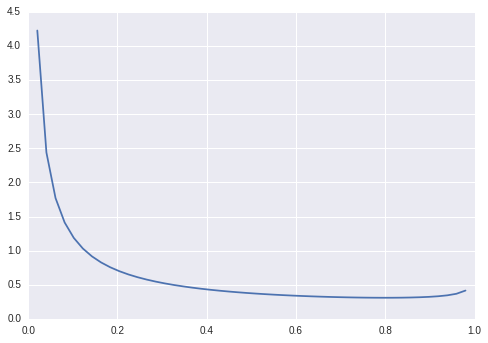

In [21]:
thetas = np.linspace(0, 1)
log_pdf = scipy.stats.beta.logpdf(thetas, prior_alpha, prior_beta)
plt.plot( thetas, np.exp(log_pdf) )